In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
import sklearn.metrics
from datetime import datetime
#import datetime
import math
from random import randrange
from tensorflow.keras import layers
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
from imblearn.over_sampling import SMOTE
from keras.layers import Flatten,ELU,LSTM,Bidirectional,Dense,TimeDistributed,Flatten,Dropout,GRU
from sklearn.model_selection import KFold

In [3]:
q1=pd.read_csv('/content/drive/MyDrive/Data/q1.csv')
q2=pd.read_csv('/content/drive/MyDrive/Data/q2.csv')
q3=pd.read_csv('/content/drive/MyDrive/Data/q3.csv')

In [5]:
diagnosis=pd.concat([q1,q2,q3],axis=0)
diagnosis.head(5)

,Patient Number;Billing Year;Billing Month;Diagnosis;Birth Year;Sex
0,10000784;2015;6;H10.8;1999;F
1,10000784;2015;6;K02.1;1999;F
2,10000784;2015;6;Z01.2;1999;F
3,10000784;2015;7;L70.0;1999;F
4,10000784;2015;8;K10.2;1999;F


In [6]:
def createData(index,df):
  #result=[]
  patient_diagnosis={}
  icd_token={}
  index=1
  for rw in range(len(df)):
    #if(df.iloc[rw].values.tolist()[0].split(';')[0]):
    id=df.iloc[rw].values.tolist()[0].split(';')[0]
    #print(df.iloc[rw])
    if(len(df.iloc[rw].values.tolist()[0].split(';'))>3):
      icd=df.iloc[rw].values.tolist()[0].split(';')[3]
      if(id in patient_diagnosis)==False:
        patient_diagnosis[id]=[]
      if (icd in icd_token)==False and icd!='F43':
        icd_token[icd]=index
        index=index+1
      else:
        patient_diagnosis[id].append(icd)
      #result.append(df.iloc[rw].values.tolist()[0].split(';')[0])
  return patient_diagnosis,icd_token
  
def cerateInputOutput(dico):
  output=[]
  for elm in dico:
    if 'F43' in dico[elm]:
      output.append(1)
      for k in range(len(dico[elm])):
        if('F43' in dico[elm]):
          dico[elm].remove('F43')
    else:
      output.append(0)
  return output,dico

In [7]:
data,icd_token=createData(0,diagnosis)
y,dico=cerateInputOutput(data)
pd.DataFrame(data=y).value_counts()#.nlargest(10).plot(kind='bar')

0    90929
1      519
dtype: int64

Checked if there is an F43 diagnostic in the input data

In [9]:
for k in data:
  if('F43' in data[k]):
    print('oups')

Maximum input length

In [10]:
len_max=0
sizes=[]
for i in data:
  sizes.append(len(data[i]))
  if len(data[i])>len_max:
    len_max=len(data[i])
print('The maximum length is:',len_max)

The maximum length is: 279


Length distribution

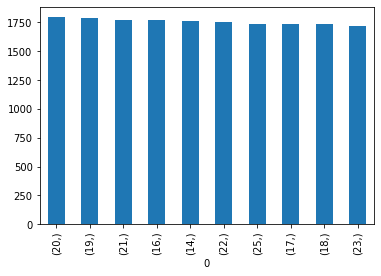

In [11]:
pd.DataFrame(data=sizes).value_counts().nlargest(10).plot(kind='bar')

In [12]:
X=[]
for i in data:
  X.append(data[i])

Encoding of each diagnosis

In [13]:
token_X=[]
for seq in X:
  tempo=[]
  for elm in seq:
    tempo.append(icd_token[elm])
  token_X.append(tempo)

Padding so that all imputs have a size of 279.

In [14]:
padded_X = tf.keras.preprocessing.sequence.pad_sequences(token_X, padding="post")

#Smote

In [15]:
smote=SMOTE(sampling_strategy="minority")
X_sm,y_sm=smote.fit_sample(padded_X,y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [16]:
pd.DataFrame(data=y_sm).value_counts()

1    90929
0    90929
dtype: int64

In [17]:
X_=X_sm
y_=y_sm

#Undersampling

In [18]:
#df_y=pd.DataFrame(data=y)
#df_y=df_y.rename(columns = {0:'label'}) 
#global_data=pd.concat([pd.DataFrame(data=padded_X),df_y],axis=1)

In [19]:
#global_data.head()

In [16]:
#df_class0=global_data.loc[global_data['label']==0,:]
#df_class1=global_data.loc[global_data['label']==1,:]

In [21]:
#df_class0_undersampling=df_class0.sample(len(df_class1))
#len(df_class0_undersampling)

In [20]:
#balanced_data=pd.concat([df_class0_undersampling,df_class1],axis=0)
#balanced_data['label'].value_counts()

In [19]:
#y_=balanced_data['label'].values
#del balanced_data['label'] 
#X_=balanced_data.values

In [22]:
#X_.shape

#Model

Parameters of k-fold cross validation


In [24]:
kfold = KFold(n_splits=2, shuffle=True)

In [26]:
fold_no = 1
aucs=[]
aucpr=[]
for train, test in kfold.split(X_,y_):

  with tf.device('/GPU:0'):
    model = tf.keras.Sequential([
        #tf.keras.layers.Dense(10, input_dim=X_.shape[1],activation='relu'),
        tf.keras.layers.Embedding(len(icd_token)+1, 100, input_length=X_.shape[1],mask_zero=True),
        #tf.keras.layers.GRU(100, return_sequences=True),
        tf.keras.layers.Flatten(),
        #tf.keras.layers.Dense(50,activation='relu'),
        # tf.keras.layers.LSTM(20),
        tf.keras.layers.Dense(1,activation='sigmoid')              
    ])

    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=["accuracy"],
    )


    model.fit(
        X_[train], 
        y_[train], 
        batch_size=10, 
        epochs=3,
        verbose=0
    )
  loss_test, accuracy_test=model.evaluate(X_[test],y_[test], verbose=0)

  y_probas = model.predict(X_[test])
  lr_precision, lr_recall, _ = precision_recall_curve(y_[test], y_probas.reshape(-1))
  auprc_ = sklearn.metrics.average_precision_score(y_[test], y_probas)

  aucpr.append(auprc_)

  m = tf.keras.metrics.AUC()
  m.update_state(y_[test], y_probas.reshape(-1))
  aucs.append(m.result().numpy())

  
  print(fold_no,'step')
  print('Accuracy:',accuracy_test)
  print('AUC',m.result().numpy())
  print('AUPRC', auprc_)
  print('**************************')

  
  yhat = model.predict_proba(X_[test])
  model_probs = yhat
  precision, recall, _ = precision_recall_curve(y_[test], model_probs)
  auc_score = sklearn.metrics.auc(recall, precision)
  #print('Logistic PR AUC: %.3f' % auc_score)

  fold_no = fold_no + 1

1 step
Accuracy: 0.9706474542617798
AUC 0.99302906
AUPRC 0.9949149979507845
**************************


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2 step
Accuracy: 0.9725280404090881
AUC 0.99313444
AUPRC 0.995244320201568
**************************


In [39]:
print("AUC: Mean {0} Standar deviation {1}".format(np.mean(np.array(aucs)),np.std(np.array(aucs))))

AUC: Mean 0.9930817484855652 Standar deviation 5.269050598144531e-05


In [42]:
print("AUCPRC: Mean {0} Standar deviation {1}".format(np.mean(np.array(aucpr)),np.std(np.array(aucpr))))

AUCPRC: Mean 0.9950796590761762 Standar deviation 0.0001646611253917074
